In [ ]:
def generate_dust_mask(
    image_shape=(1024, 1024),  # Increased default size
    num_blobs=30,
    num_scratches=6,
    num_hairs=20,
    max_blob_size=2,
    max_scratch_length=300,
    max_hair_length=100,
    squiggliness=0.9,
    blur_kernel=(3, 3)
):
    """
    Returns a float32 dust mask with values from ~0.3 to 1.0 (not binary).
    Enhanced with more randomness and particle variety for better training diversity.
    """
    h, w = image_shape
    mask = np.zeros((h, w), dtype=np.float32)

    def rand_count(base):
        return random.randint(int(base * 0.2), int(base * 3.0))  # Even more variation

    # Much more diverse parameters
    num_blobs = rand_count(num_blobs)
    num_scratches = rand_count(num_scratches)
    num_hairs = rand_count(num_hairs)
    
    # Add random dust clusters (groups of small particles)
    num_clusters = random.randint(2, 8)
    
    # Vary all sizes more dramatically
    max_blob_size = random.randint(1, 12)

    # Dust blobs (ellipses) with more shape variety
    for _ in range(num_blobs):
        temp = np.zeros_like(mask)
        center = (random.randint(0, w), random.randint(0, h))
        
        # More dramatic size variations and random aspect ratios
        major_axis = random.randint(1, max_blob_size)
        minor_axis = random.randint(1, max(1, int(major_axis * random.uniform(0.3, 1.0))))
        axes = (major_axis, minor_axis)
        
        angle = random.randint(0, 180)
        cv2.ellipse(temp, center, axes, angle, 0, 360, 1.0, -1)
        
        # Wider opacity range and sometimes very faint particles
        opacity = random.choice([
            random.uniform(0.2, 0.5),  # Very faint particles
            random.uniform(0.5, 0.8),  # Medium particles  
            random.uniform(0.8, 1.0)   # Strong particles
        ])
        mask += temp * opacity

    # Add dust clusters (concentrated areas)
    for _ in range(num_clusters):
        cluster_center = (random.randint(w//4, 3*w//4), random.randint(h//4, 3*h//4))
        cluster_radius = random.randint(30, 100)
        cluster_density = random.randint(5, 20)
        
        for _ in range(cluster_density):
            # Generate particles around cluster center
            offset_x = random.randint(-cluster_radius, cluster_radius)
            offset_y = random.randint(-cluster_radius, cluster_radius)
            center = (
                max(0, min(w-1, cluster_center[0] + offset_x)),
                max(0, min(h-1, cluster_center[1] + offset_y))
            )
            
            temp = np.zeros_like(mask)
            size = random.randint(1, 4)
            cv2.circle(temp, center, size, 1.0, -1)
            opacity = random.uniform(0.3, 0.7)
            mask += temp * opacity

    # Scratches with much more variation
    for _ in range(num_scratches):
        temp = np.zeros_like(mask)
        x1, y1 = random.randint(0, w), random.randint(0, h)
        
        # Random scratch types
        scratch_type = random.choice(['straight', 'curved', 'jagged'])
        
        if scratch_type == 'straight':
            angle = random.uniform(0, 2 * np.pi)
            length = random.randint(20, max_scratch_length * 3)
            x2 = int(x1 + length * np.cos(angle))
            y2 = int(y1 + length * np.sin(angle))
            thickness = random.randint(1, 4)
            cv2.line(temp, (x1, y1), (x2, y2), 1.0, thickness)
            
        elif scratch_type == 'curved':
            # Create curved scratch with multiple segments
            points = [(x1, y1)]
            angle = random.uniform(0, 2 * np.pi)
            for i in range(random.randint(3, 8)):
                angle += random.uniform(-0.5, 0.5)  # Curve the line
                length = random.randint(20, 60)
                x1 += int(length * np.cos(angle))
                y1 += int(length * np.sin(angle))
                x1 = max(0, min(w-1, x1))
                y1 = max(0, min(h-1, y1))
                points.append((x1, y1))
            
            for i in range(len(points)-1):
                thickness = random.randint(1, 3)
                cv2.line(temp, points[i], points[i+1], 1.0, thickness)
        
        else:  # jagged
            # Create jagged scratch
            for _ in range(random.randint(5, 15)):
                x2 = x1 + random.randint(-30, 30)
                y2 = y1 + random.randint(-30, 30)
                x2 = max(0, min(w-1, x2))
                y2 = max(0, min(h-1, y2))
                cv2.line(temp, (x1, y1), (x2, y2), 1.0, 1)
                x1, y1 = x2, y2
        
        opacity = random.uniform(0.2, 1.0)
        mask += temp * opacity

    # Hairs with much more variety
    for _ in range(num_hairs):
        temp = np.zeros_like(mask)
        points = []
        x, y = random.randint(0, w), random.randint(0, h)
        
        # Random hair types
        hair_type = random.choice(['wavy', 'straight', 'kinky', 'spiral'])
        hair_length = random.randint(40, max_hair_length * 3)
        
        if hair_type == 'wavy':
            num_segments = max(5, hair_length // random.randint(8, 20))
            hair_squiggliness = random.uniform(0.5, 2.0)
            angle = random.uniform(0, 2 * np.pi)
            dx_base = np.cos(angle)
            dy_base = np.sin(angle)
            
            for i in range(num_segments):
                segment_length = random.uniform(8, 25)
                wave_intensity = hair_squiggliness * (1 + 0.5 * np.sin(i * 0.3))
                dx = dx_base * segment_length + wave_intensity * random.uniform(-segment_length, segment_length)
                dy = dy_base * segment_length + wave_intensity * random.uniform(-segment_length, segment_length)
                x = int(np.clip(x + dx, 0, w - 1))
                y = int(np.clip(y + dy, 0, h - 1))
                points.append((x, y))
                
        elif hair_type == 'spiral':
            center_x, center_y = x, y
            radius = random.randint(20, 80)
            turns = random.uniform(1, 4)
            num_points = random.randint(20, 60)
            
            for i in range(num_points):
                angle = (i / num_points) * turns * 2 * np.pi
                current_radius = radius * (i / num_points)
                x = int(center_x + current_radius * np.cos(angle))
                y = int(center_y + current_radius * np.sin(angle))
                x = max(0, min(w-1, x))
                y = max(0, min(h-1, y))
                points.append((x, y))
                
        else:  # straight or kinky
            angle = random.uniform(0, 2 * np.pi)
            kink_factor = 2.0 if hair_type == 'kinky' else 0.1
            
            for i in range(random.randint(10, 30)):
                segment_length = random.uniform(10, 30)
                angle += random.uniform(-kink_factor, kink_factor)
                x += int(segment_length * np.cos(angle))
                y += int(segment_length * np.sin(angle))
                x = max(0, min(w-1, x))
                y = max(0, min(h-1, y))
                points.append((x, y))

        # Draw hair with variable thickness
        thickness = random.randint(1, 3)
        for i in range(len(points) - 1):
            cv2.line(temp, points[i], points[i + 1], 1.0, thickness)

        opacity = random.uniform(0.2, 1.0)
        mask += temp * opacity

    # Add some water spots or stains (circular with soft edges)
    num_spots = random.randint(0, 5)
    for _ in range(num_spots):
        temp = np.zeros_like(mask)
        center = (random.randint(0, w), random.randint(0, h))
        radius = random.randint(10, 40)
        cv2.circle(temp, center, radius, 1.0, -1)
        
        # Soft edges with gaussian blur
        temp = cv2.GaussianBlur(temp, (15, 15), 0)
        opacity = random.uniform(0.1, 0.4)
        mask += temp * opacity

    # Variable blur intensity with different kernel sizes
    blur_choice = random.choice([1, 3, 5, 7])
    if blur_choice > 1:
        mask = cv2.GaussianBlur(mask, (blur_choice, blur_choice), 0)

    # Sometimes add motion blur for scanning artifacts
    if random.random() < 0.2:
        kernel_size = random.choice([3, 5, 7])
        kernel = np.zeros((kernel_size, kernel_size))
        if random.random() < 0.5:  # Horizontal motion blur
            kernel[kernel_size//2, :] = 1
        else:  # Vertical motion blur
            kernel[:, kernel_size//2] = 1
        kernel = kernel / kernel.sum()
        mask = cv2.filter2D(mask, -1, kernel)

    # Normalize mask to [0, 1] but allow for more dynamic range
    mask = np.clip(mask, 0.0, 1.0)

    return mask

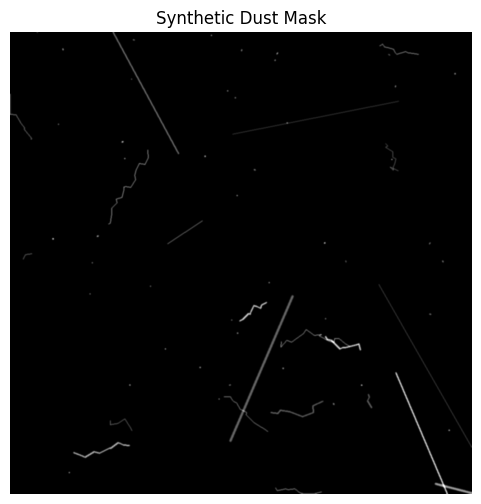

In [148]:
import matplotlib.pyplot as plt

mask = generate_dust_mask(image_shape=(1024, 1024))

plt.figure(figsize=(6, 6))
plt.imshow(mask, cmap='gray', interpolation='bilinear')
plt.title("Synthetic Dust Mask")
plt.axis('off')
plt.show()

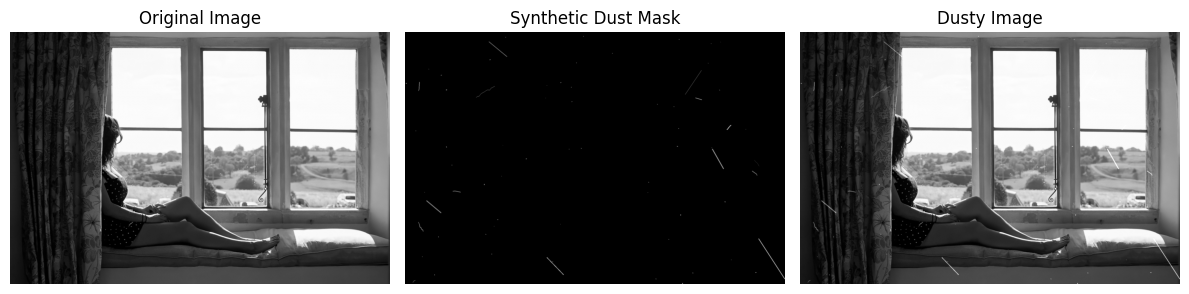

In [149]:
def apply_dust_to_greyscale_image(image_grey, mask, intensity=255):
    mask_float = mask.astype(np.float32)  # Already in [0.0, 1.0]
    image_float = image_grey.astype(np.float32)
    image_float += mask_float * intensity
    return np.clip(image_float, 0, 255).astype(np.uint8)

# ---- Load Image ----
img_path = "film-dataset/1216x806x2 (8)-topaz-denoise.jpeg"
image = cv2.imread(img_path)
if image is None:
    raise FileNotFoundError(f"Could not read {img_path}")

# Convert to greyscale
image_grey = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
h, w = image_grey.shape

# ---- Generate Mask & Apply ----
mask = generate_dust_mask(image_shape=(h, w), squiggliness=0.7)
dusty_image = apply_dust_to_greyscale_image(image_grey, mask, intensity=255)

# ---- Visualize ----
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(image_grey, cmap='gray')
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(mask, cmap='gray')
plt.title("Synthetic Dust Mask")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(dusty_image, cmap='gray')
plt.title("Dusty Image")
plt.axis('off')

plt.tight_layout()
plt.show()

In [150]:
plt.imsave("dusty_image.png", dusty_image, cmap='gray')

In [172]:
!pip install torch torchvision albumentations matplotlib scikit-image opencv-python tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.9/37.9 MB 17.1 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5/5 [albumentations]m [albucore]thon-headless]


In [151]:
from torch.utils.data import Dataset
import cv2
import numpy as np
import os
from torchvision import transforms

class DustDataset(Dataset):
    def __init__(self, root_dir, image_size=(512, 512), transform=None):
        self.root_dir = root_dir
        self.image_paths = [os.path.join(root_dir, f) for f in os.listdir(root_dir)
                            if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
        self.image_size = image_size
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        path = self.image_paths[idx]
        clean_img = cv2.imread(path)
        
        # Convert to greyscale
        if len(clean_img.shape) == 3:
            clean_img = cv2.cvtColor(clean_img, cv2.COLOR_BGR2GRAY)
        
        # Resize image
        clean_img = cv2.resize(clean_img, self.image_size)

        # generate synthetic dust mask
        mask = generate_dust_mask(image_shape=self.image_size, squiggliness=0.7)

        # apply dust to the clean image using the mask
        dusty_img = apply_dust_to_greyscale_image(clean_img, mask, intensity=200)

        # Normalize and prepare inputs - convert greyscale to single channel format
        image = dusty_img.astype(np.float32) / 255.0
        image = image[..., np.newaxis]  # Add channel dimension: HW -> HW1
        mask = mask.astype(np.float32)[..., np.newaxis]

        # Apply augmentation (optional)
        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']

        # CHW format
        image = np.transpose(image, (2, 0, 1))
        mask = np.transpose(mask, (2, 0, 1))

        return image, mask

In [152]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

# Augmentations for greyscale images (removing RGB-only transforms)
transform = A.Compose([
    # Geometric transforms - films can be scanned at slight angles
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.3),
    A.Rotate(limit=5, p=0.4),  # Small rotations for scanning variations
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.1, rotate_limit=3, p=0.3),
    
    
    # Subtle blur for focus variations
    A.OneOf([
        A.Blur(blur_limit=3, p=1.0),
        A.MotionBlur(blur_limit=3, p=1.0),
        A.GaussianBlur(blur_limit=3, p=1.0),
    ], p=0.2),
    
    # Grid distortions for film warping/stretching
    A.GridDistortion(num_steps=5, distort_limit=0.1, p=0.2),
    A.ElasticTransform(alpha=1, sigma=20, alpha_affine=10, p=0.1),
    
    # Dropout augmentations - simulate missing pixels or scanner artifacts
    A.CoarseDropout(max_holes=8, max_height=16, max_width=16, 
                    min_holes=3, min_height=8, min_width=8, p=0.2),
    
    # Compression artifacts simulation
    A.ImageCompression(quality_lower=70, quality_upper=95, p=0.2),
])

/home/yrahhawi/.conda/envs/pytorch/lib/python3.10/site-packages/albumentations/core/validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/tmp/ipykernel_1050210/2299319714.py:22: UserWarning: Argument(s) 'alpha_affine' are not valid for transform ElasticTransform
  A.ElasticTransform(alpha=1, sigma=20, alpha_affine=10, p=0.1),
/tmp/ipykernel_1050210/2299319714.py:25: UserWarning: Argument(s) 'max_holes, max_height, max_width, min_holes, min_height, min_width' are not valid for transform CoarseDropout
  A.CoarseDropout(max_holes=8, max_height=16, max_width=16,
/tmp/ipykernel_1050210/2299319714.py:29: UserWarning: Argument(s) 'quality_lower, quality_upper' are not valid for transform ImageCompression
  A.ImageCompression(quality_lower=70, quality_upper=95, p=0.2),


In [153]:
import torch
import torch.nn as nn

class UNet(nn.Module):
    def __init__(self):
        super().__init__()

        def conv_block(in_c, out_c):
            return nn.Sequential(
                nn.Conv2d(in_c, out_c, 3, padding=1), nn.ReLU(),
                nn.Conv2d(out_c, out_c, 3, padding=1), nn.ReLU()
            )

        # Back to 1 channel for greyscale
        self.enc1 = conv_block(1, 64)
        self.enc2 = conv_block(64, 128)
        self.enc3 = conv_block(128, 256)
        self.enc4 = conv_block(256, 512)

        self.pool = nn.MaxPool2d(2)

        self.middle = conv_block(512, 1024)

        self.up4 = nn.ConvTranspose2d(1024, 512, 2, stride=2)
        self.dec4 = conv_block(1024, 512)
        self.up3 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.dec3 = conv_block(512, 256)
        self.up2 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.dec2 = conv_block(256, 128)
        self.up1 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.dec1 = conv_block(128, 64)

        self.final = nn.Conv2d(64, 1, 1)

    def forward(self, x):
        e1 = self.enc1(x)           # 512
        e2 = self.enc2(self.pool(e1))  # 256
        e3 = self.enc3(self.pool(e2))  # 128
        e4 = self.enc4(self.pool(e3))  # 64

        m = self.middle(self.pool(e4))  # 32

        d4 = self.dec4(torch.cat([self.up4(m), e4], dim=1))  # 64
        d3 = self.dec3(torch.cat([self.up3(d4), e3], dim=1)) # 128
        d2 = self.dec2(torch.cat([self.up2(d3), e2], dim=1)) # 256
        d1 = self.dec1(torch.cat([self.up1(d2), e1], dim=1)) # 512

        return torch.sigmoid(self.final(d1))  # 1x512x512

In [154]:
import torch
import torch.nn as nn

def dice_bce_loss(pred, target, smooth=1e-5):
    """Combined Dice and BCE loss for better segmentation performance"""
    bce = nn.BCELoss()(pred, target)
    
    # Flatten tensors for dice calculation
    pred_flat = pred.view(-1)
    target_flat = target.view(-1)
    
    intersection = (pred_flat * target_flat).sum()
    dice = (2 * intersection + smooth) / (pred_flat.sum() + target_flat.sum() + smooth)
    
    return bce + (1 - dice)

In [155]:
from torch.utils.data import DataLoader
from tqdm import tqdm

device = torch.device("mps" if torch.backends.mps.is_available() else "cuda")
dataset = DustDataset("film-dataset", transform=transform)
loader = DataLoader(dataset, batch_size=8, shuffle=True)

model = UNet().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# Add learning rate scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', patience=5, factor=0.5, verbose=True
)

for epoch in range(30):
    model.train()
    total_loss = 0
    for images, masks in tqdm(loader):
        images = images.to(device)
        masks = masks.to(device)

        preds = model(images)
        loss = dice_bce_loss(preds, masks)  # Use new loss function

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(loader)
    print(f"Epoch {epoch+1}: Loss = {avg_loss:.4f}")
    
    # Step scheduler
    scheduler.step(avg_loss)

/home/yrahhawi/.conda/envs/pytorch/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
100%|██████████| 79/79 [01:09<00:00,  1.13it/s]


Epoch 1: Loss = 1.2194


100%|██████████| 79/79 [01:09<00:00,  1.13it/s]


Epoch 2: Loss = 1.0558


100%|██████████| 79/79 [01:10<00:00,  1.12it/s]


Epoch 3: Loss = 0.8134


100%|██████████| 79/79 [01:10<00:00,  1.13it/s]


Epoch 4: Loss = 0.6732


100%|██████████| 79/79 [01:10<00:00,  1.13it/s]


Epoch 5: Loss = 0.6230


100%|██████████| 79/79 [01:10<00:00,  1.13it/s]


Epoch 6: Loss = 0.6179


100%|██████████| 79/79 [01:10<00:00,  1.12it/s]


Epoch 7: Loss = 0.5953


100%|██████████| 79/79 [01:10<00:00,  1.13it/s]


Epoch 8: Loss = 0.5887


100%|██████████| 79/79 [01:09<00:00,  1.13it/s]


Epoch 9: Loss = 0.5787


100%|██████████| 79/79 [01:10<00:00,  1.12it/s]


Epoch 10: Loss = 0.5823


  3%|▎         | 2/79 [00:02<01:19,  1.03s/it]


KeyboardInterrupt: 

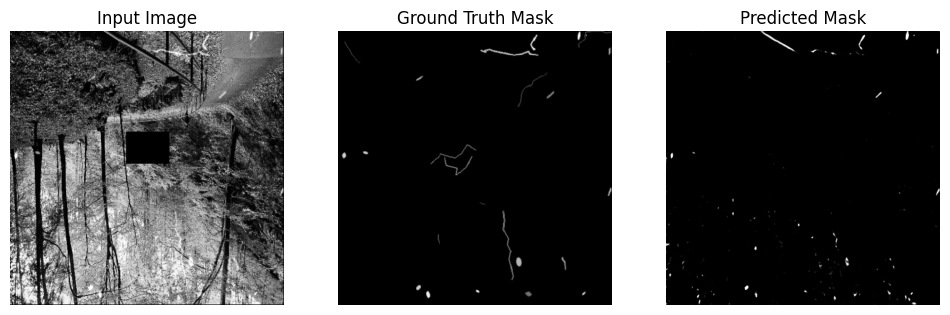

In [165]:
model.eval()
with torch.no_grad():
    images, masks = next(iter(loader))
    preds = model(images.to(device)).cpu()

# Plot side-by-side for sanity check

plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(images[0].squeeze(), cmap='gray')
plt.title("Input Image")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(masks[0].squeeze(), cmap='gray')
plt.title("Ground Truth Mask")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(preds[0].squeeze(), cmap='gray')
plt.title("Predicted Mask")
plt.axis('off')

plt.show()

In [223]:
plt.imsave("predicted_mask.png", np.transpose(preds[0].numpy(), (1, 2, 0)).squeeze(), cmap='gray')

In [ ]:
plt.imsave("input_image.png", images[0].squeeze(), cmap='gray')

100%|██████████| 9/9 [00:01<00:00,  6.56it/s]


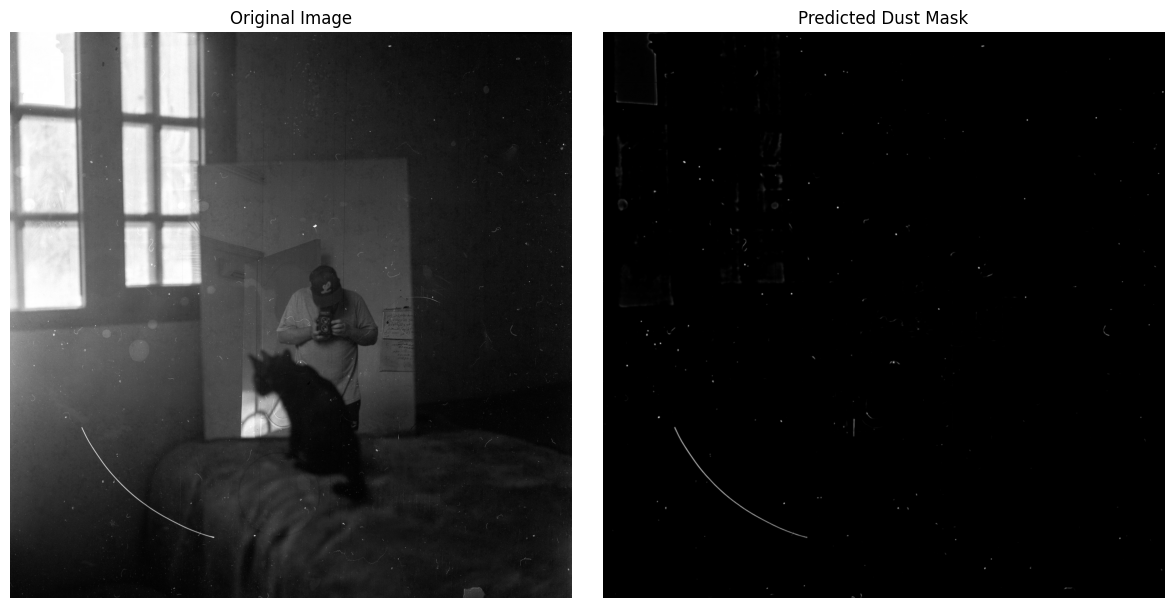

In [141]:
from PIL import Image
import numpy as np
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm

# --- CONFIG ---
PATCH_SIZE = 512
STRIDE = 128  # Overlap of 50% for better edge blending
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- Load original image ---
img_path = "/home/yrahhawi/Dust_Removal_UNET/ik.el_1742160314_3589823361089339939_2300898238.jpg"
image = Image.open(img_path).convert('L')
image_np = np.array(image)
H, W = image_np.shape

# --- Pad image if needed ---
pad_h = (PATCH_SIZE - H % PATCH_SIZE) % PATCH_SIZE
pad_w = (PATCH_SIZE - W % PATCH_SIZE) % PATCH_SIZE
padded = np.pad(image_np, ((0, pad_h), (0, pad_w)), mode='reflect')
pH, pW = padded.shape

# --- Prepare tensors for stitching ---
prediction_map = np.zeros((pH, pW), dtype=np.float32)
count_map = np.zeros((pH, pW), dtype=np.float32)

# --- Run inference in patches ---
model.eval()
with torch.no_grad():
    for y in tqdm(range(0, pH - PATCH_SIZE + 1, STRIDE)):
        for x in range(0, pW - PATCH_SIZE + 1, STRIDE):
            patch = padded[y:y+PATCH_SIZE, x:x+PATCH_SIZE]
            patch_tensor = torch.from_numpy(patch).float().unsqueeze(0).unsqueeze(0) / 255.0
            patch_tensor = patch_tensor.to(device)

            pred = model(patch_tensor)
            pred = torch.sigmoid(pred).squeeze().cpu().numpy()

            prediction_map[y:y+PATCH_SIZE, x:x+PATCH_SIZE] += pred
            count_map[y:y+PATCH_SIZE, x:x+PATCH_SIZE] += 1.0

# --- Normalize stitched output ---
final_mask = prediction_map / count_map
final_mask = final_mask[:H, :W]  # Crop back to original size

# --- Display ---
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(image_np, cmap='gray')
axes[0].set_title("Original Image")
axes[0].axis('off')

axes[1].imshow(final_mask, cmap='gray')
axes[1].set_title("Predicted Dust Mask")
axes[1].axis('off')

plt.tight_layout()
plt.show()

In [142]:
import skimage.io as skio
import skimage
final_mask = skimage.img_as_ubyte(final_mask > 0.51)
skio.imsave("final_mask.jpg", final_mask)

/home/yrahhawi/.conda/envs/pytorch/lib/python3.10/site-packages/skimage/_shared/utils.py:328: UserWarning: final_mask.jpg is a low contrast image
  return func(*args, **kwargs)


/tmp/ipykernel_1050210/644803635.py:1: FutureWarning: `imshow` is deprecated since version 0.25 and will be removed in version 0.27. Please use `matplotlib`, `napari`, etc. to visualize images.
  skio.imshow(final_mask > 0.51)


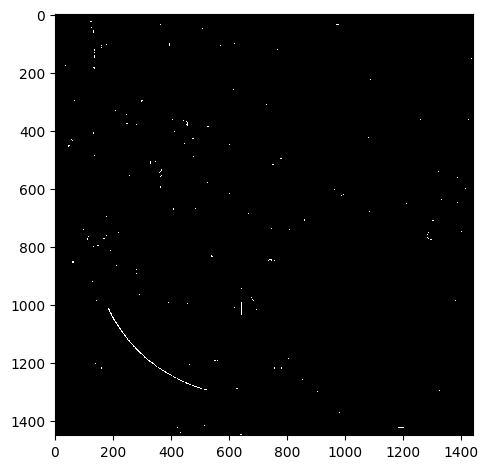

In [140]:
skio.imshow(final_mask > 0.51)